<a href="https://colab.research.google.com/github/NirajBagh/Detection-of-Remaining-Useful-Life-of-the-Machine/blob/main/RUL_Detections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONDITION MONITORING & PREDICTIVE MAINTENANCE

This notebook is intended to illustrate conditioning monitoring of industrial machinery by walking through a real life dataset of bearing vibration data.Generally, conditioning monitoring of a machine is done by looking at a sensor mesurement (Eg. Temperature, Vibration ) and imposing bounds to it, i.e. under normal operating conditions, the measurement values are bounded by a maximum and minimum value (similar to control charts). Any deviation is the defined bounds sends an alarm. This is often generally defined as anamoly detection.

However, this method often sends false alarms (false positives) or misses an alarm (false negative). Furthermore, a single signal is observed/analysed in isolation. For example, an alarm may sound if the temperature exceeeds a certain level. A system defined above often cannot look at mutiple parameters and come to a conclusion about the state of a machine. Or technical parlance, one cannot take advantage of the multi-dimensionality of the data.

This is where machine learning and other AI based techniques step in.

This notes walks one through anamoly detection of a single dimension data (vibration). This is easier to visualise. The same principles hold true for mutildimensional data as well.

#Machine Learning Anamoly Detection Engine

A Machine Learning Anomaly Detection (MLAD) Engine uses sensor data like tempearture, flow, vibration and other variables (multi-dimensional) to create a multi-dimensional pattern ., i.e. the state of a machine is "learned" under healthy operating conditions. By learning the healthy state, the engine guages if an alert should be triggered or not under any deviation.

The second step is to forecast the probability of future breakdown or in other words, asses the RUL (Residual Useful Life) of a machine. This provides valuable information regarding urgent repairs or regarding planned maintenance activity.

Finally, can integrate them into dashboards or into alarm systems that will be monitored by maintenance teams.

# The Dataset

The dataset is sourced from the NASA repo https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/.

Dataset Citation : J. Lee, H. Qiu, G. Yu, J. Lin, and Rexnord Technical Services (2007). IMS, University of Cincinnati. "Bearing Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA

# Loading of Data

In [ ]:
# Common imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/Machine life detection/2nd_test'
merged_data = pd.DataFrame()

# Looping over all files from 12th Feb to 19th Feb
for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = pd.concat([merged_data, dataset_mean_abs], ignore_index=False)

# Renaming columns
merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
# Identifying index as datetime format
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')

In [ ]:
# Check - Begining of Data
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [ ]:
# Check - End of Data
merged_data.tail()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786
2004-02-19 06:22:39,0.001168,0.000767,0.000716,0.001699


In [ ]:
#Check Total Points
print(f'Total Data Points {merged_data.shape[0] + 1}')

Total Data Points 985


# Visualization of data

Text(2004-02-19 06:12:39, 0.3, 'Breakdown of Bearing 1')

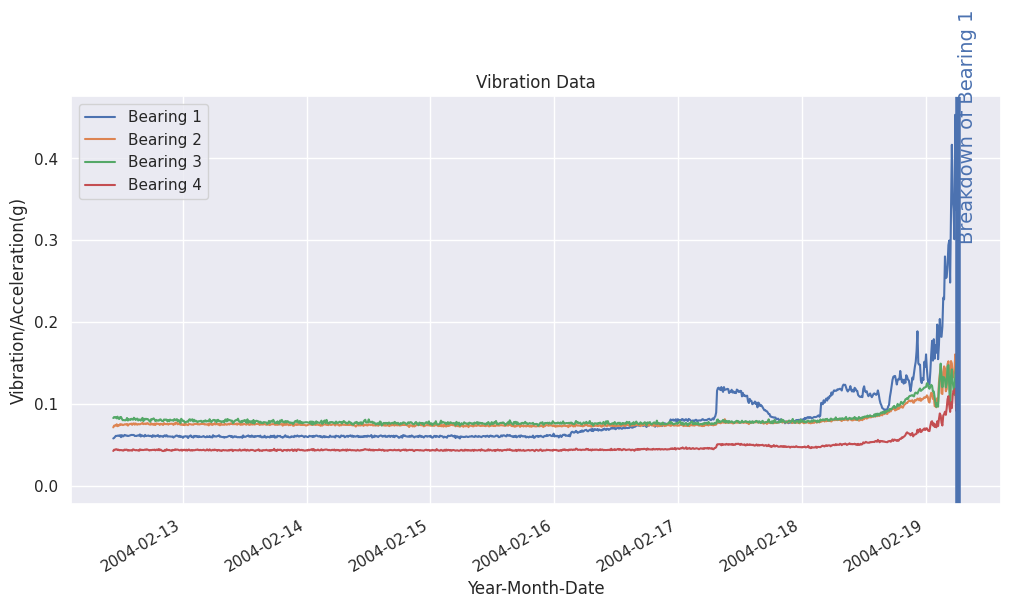

In [ ]:
# Visualising Data
ax = merged_data.plot(figsize = (12,6), title="Vibration Data" , legend = True)
ax.set(xlabel="Year-Month-Date", ylabel="Vibration/Acceleration(g)")
plt.axvline(x='2004-02-19 06:12:39', linewidth=4, color='b', label ="Breakdown of Bearing 1")
plt.text('2004-02-19 06:12:39',0.3,'Breakdown of Bearing 1',rotation=90, fontsize=14, color='b')

The above figure shows the accelereometer data for all four bearings. Bearing 1 fails at end of measurement, @ 2004-02-19 06:22:39.

Observing the time plot, it is pretty obvious that the vibration increases after 2004-02-16. However, how does a machine access that there has been an increase in bearing vibration?

#Zooming in Data for Bearing 1

[Text(0.5, 0, 'Month-Date Time'), Text(0, 0.5, 'Vibration/Acceleration(g)')]

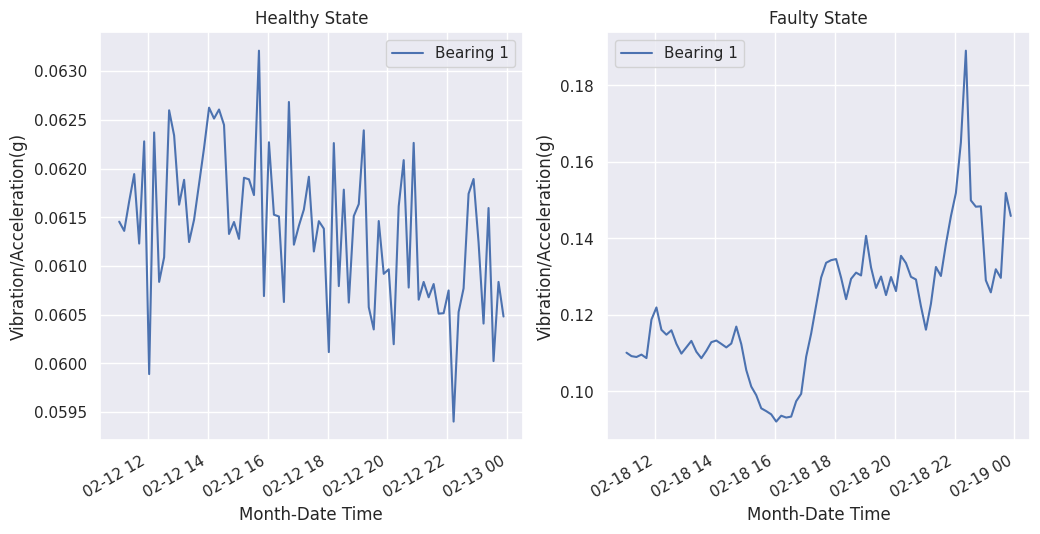

In [ ]:
fig = plt.figure()

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)

healthy =merged_data['2004-02-12 11:02:39':'2004-02-12 23:52:39']
healthy['Bearing 1'].plot(figsize = (12,6), title="Healthy State" , legend = True, ax=ax1)
ax1.set(xlabel="Month-Date Time", ylabel="Vibration/Acceleration(g)")

faulty =merged_data['2004-02-18 11:02:39':'2004-02-18 23:52:39']
ax2 = faulty['Bearing 1'].plot(figsize = (12,6), title="Faulty State" , legend = True, ax= ax2)
ax2.set(xlabel="Month-Date Time", ylabel="Vibration/Acceleration(g)")



The above graphs shows the vibration data fro bearing 1 at the for the same time peiod , '11:02:39' to "23:52:39' on 12th (Healthy) and on the 18th(Faulty/Poor Heath Score).

The vibration is definetly higher. Furthermore, the frequency component are also different. It is easy to identify for one variable (one dimension). However, when the number of variables (dimensions) increase, i.e. when we consider more variable likes temperature, humidity etc., the complexity increases.

The beauty of ML lies in the fact that the same methods hold true for mutli dimensional data as well. Multiple sensor variables (dimensions) can be considered to get a more accurate measure of the "Health Score" of a machine.

#Anamoly Detection using Prophet Package

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

#Creating Training Data Set

The training of the anamoly detection model is using data from the healthy phase of the bearing. The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
healthy_bearing1 = merged_data['2004-02-12 10:32:39':'2004-02-15 23:42:39']['Bearing 1']

# Creating training dataframe
prophet_healthy_train = pd.DataFrame()
prophet_healthy_train['ds'] = healthy_bearing1.index
prophet_healthy_train['y'] = healthy_bearing1.values

prophet_healthy_train.head()

,ds,y
0,2004-02-12 10:32:39,0.058333
1,2004-02-12 10:42:39,0.058995
2,2004-02-12 10:52:39,0.060236
3,2004-02-12 11:02:39,0.061455
4,2004-02-12 11:12:39,0.061361


# Creating the Model

Calling the In-Bulit Prophet Module for training a model

In [ ]:
m = Prophet(interval_width = 1)
# Using the training data from "healthy part"
m.fit(prophet_healthy_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhxl4h7s/sxty9w5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhxl4h7s/udtuda6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63587', 'data', 'file=/tmp/tmprhxl4h7s/sxty9w5i.json', 'init=/tmp/tmprhxl4h7s/udtuda6p.json', 'output', 'file=/tmp/tmprhxl4h7s/prophet_modeln695vpy7/prophet_model-20241002063548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:35:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Evaluation on Training Data

Displaying Prophet plot


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


[Text(0.5, 32.249999999999986, 'Month (MM)-Date(DD) Time'),
 Text(62.625, 0.5, 'Vibration/Acceleration(g)')]

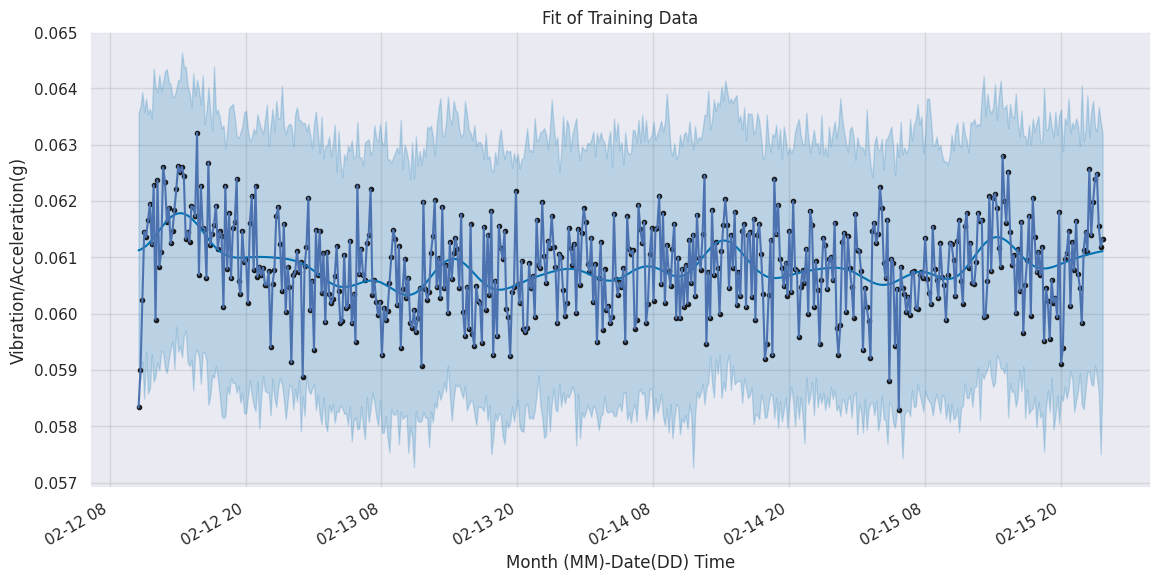

In [ ]:
forecast = m.predict(prophet_healthy_train)
forecast['fact'] = prophet_healthy_train['y'].reset_index(drop = True)
print('Displaying Prophet plot')
fig1 = m.plot(forecast)
fig1 = healthy_bearing1.plot(figsize = (12,6), title="Fit of Training Data")
fig1.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")


The black points are the true data points of the vibration sensor. The blue line represents the fitted line (trend line) with the light blue portion showing the acceptable variance.

# Evaluation on Test Data (Unseen, Fault Data)

<ipython-input-79-8a0dbfbfc011>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prophet_faultydata_subset = prophet_faultydata.resample('H').mean()  # Resample to hourly data
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Displaying Prophet plot


Text(12462.0, 0.063, 'Healthy')

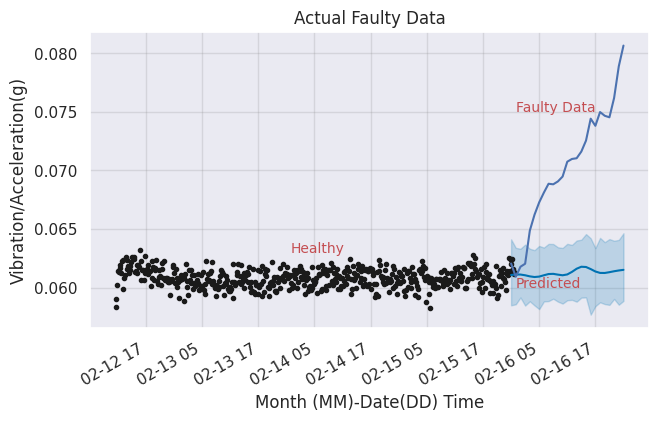

In [ ]:
# Reduce data points (assuming prophet_faultydata is your full data)
prophet_faultydata_subset = prophet_faultydata.resample('H').mean()  # Resample to hourly data

# Prepare data for Prophet model
prophet_faulty_test = pd.DataFrame()
prophet_faulty_test['ds'] = prophet_faultydata_subset.index
prophet_faulty_test['y'] = prophet_faultydata_subset.values

# Forecast and plot with reduced figure size
forecast = m.predict(prophet_faulty_test)
forecast['fact'] = prophet_faultydata_subset.reset_index(drop=True)
print('Displaying Prophet plot')
fig1 = m.plot(forecast, figsize=(4, 3))  # Reduce figure size

# Plot actual faulty data on a separate figure (optional)
fig2 = prophet_faultydata_subset.plot(figsize=(8, 4), title="Actual Faulty Data")
fig2.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")
fig2.text(12464.0, 0.06, 'Predicted',fontsize=10, color='r')
fig2.text(12464.0,0.075,'Faulty Data', fontsize=10, color='r')
fig2.text(12462.0,0.063,'Healthy', fontsize=10, color='r')

The black points are the true data points of the vibration sensor. The blue line represents the expected values from 2004-02-15, 23:42:39 with the light blue portion showing the acceptable variance.

Clearly, the values are higher than the predicted values and an alarm can be sounded.

#Conclusion

Using this predictive maintenace strategies, one can find the earliest stages of damage and reduce operating costs. Rather than shutting down equipment for scheduled preventive maintenance routines, maintenance can be planned to match convenient schedules and improve reliability. Predictive maintenance uses sensors, machine learning, and advanced algorithms to detect faults and predict failure. Connecting to the Industrial Internet of Things (IIoT) enables access to historical baseline data while building the statistical and trend analyses that point to why and where problems occur and what actions are needed.